In [102]:
from collections import defaultdict
import functools
from glob import glob
import os
import re

import numpy as np
from matplotlib import pylab as plt
import torch
try:
    import tqdm
    progress = tqdm.tqdm
except ModuleNotFoundError:
    progress = lambda x, *args : x

from odenet import refine_train
from odenet import ode_models
from odenet import datasets
from odenet import odenet_cifar10
from odenet import plotting
from odenet import helper

In [103]:
import importlib
importlib.reload(refine_train)
importlib.reload(ode_models)
importlib.reload(odenet_cifar10)
importlib.reload(datasets)

<module 'odenet.datasets' from '/home/ubuntu/afq_odenet/ODENet/odenet/datasets.py'>

In [104]:
legend_name = lambda fname : re.search(r"ARCH(.*)", fname)[1]

In [105]:
dirs = glob('results/*CIFAR*160*') + glob('results/*CIFAR*200*')
dirs = sorted(dirs, key = lambda x : os.stat(x).st_mtime)[:]
results = { name: torch.load(name) for name in dirs }
dirs

['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl',
 'results/odenet

# Just stating the latest loaded plots

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.906
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9091
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9173
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9263
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9187
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9294
results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl 0.9

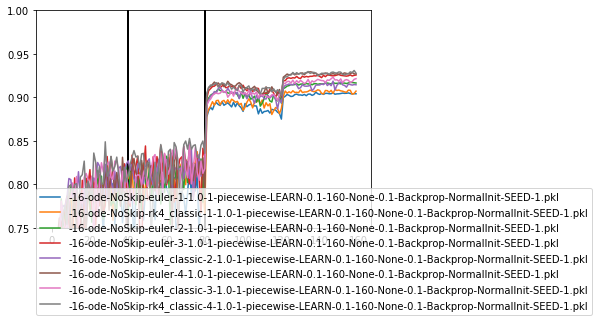

In [106]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    x,y = zip(*result.test_acc)
    plt.plot(x,y, '-', label=legend_name(name))
    try:
        x,y = zip(*result.train_acc)
        plt.plot(x,y, '--', label=legend_name(name))
    except: pass
    print((name),
          max(list(zip(*result.test_acc))[1]),)
          #max(list(zip(*result.train_acc))[1]))
    plt.vlines([40,80],0,1)
plt.ylim(0.75,1)
plt.legend(loc=(0,-0.4))

# Plots for Adjoint performance

In [57]:
def legend_name(fname):
    mat = re.search(r".*(euler|rk4_classic)-([0-9])-.*([0-9])-piecewise.*(Adjoint|Backprop).*-NormalInit", fname)
    return mat[1], mat[2], mat[3], mat[4]
for name, result in results.items():
    print(legend_name(name), "|", np.average(result.epoch_times), "s")

('rk4_classic', '2', '1', 'Backprop') | 55.18050939145003 s
('rk4_classic', '8', '1', 'Backprop') | 73.52393591061492 s
('rk4_classic', '2', '1', 'Backprop') | 45.121386028987175 s


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


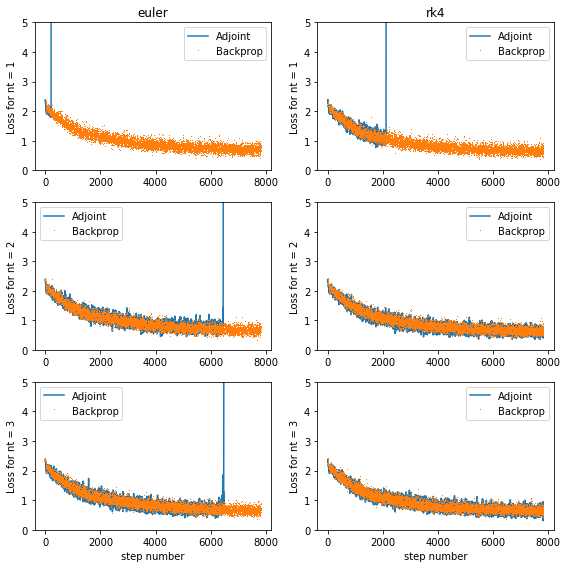

In [124]:
plt.figure(figsize=(8,8))
for i,(name, result) in enumerate(results.items()):
    if "euler" in name:
        horiz = 0
    else:
        horiz = 1
    if "-1-" in name:
        vert = 0
    elif "-2-" in name:
        vert = 1
    else:
        vert = 2

    plt.subplot(3,2,1+horiz+2*vert)
    if horiz==0 and vert==0:
        plt.title("euler")
    if horiz==1 and vert==0:
        plt.title("rk4")
    if vert==2:
        plt.xlabel("step number")
    plt.ylabel(f"Loss for nt = { vert+1}")
    plt.plot(result.losses,
             '-' if "Adjoint" in name else ',',
             label="Adjoint" if "Adjoint" in name else "Backprop")
    #plt.vlines(result.refine_steps, 0,1, linestyle='dashed')
    plt.legend()
    plt.ylim(0.,5)
plt.tight_layout()


ValueError: not enough values to unpack (expected 2, got 0)

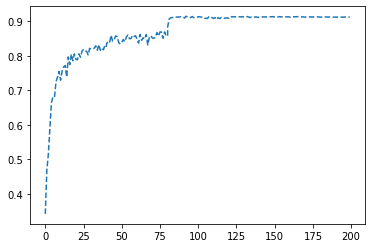

In [58]:
for name, result in results.items():
    #plt.plot(result.train_acc, label=legend_name(name))
    x,y = zip(*result.test_acc)
    plt.plot(x,y, '--', label=legend_name(name))
    x,y = zip(*result.train_acc)
    plt.plot(x,y, '--', label=legend_name(name))
    print((name), max(result.test_acc))
    plt.vlines([50,],0,1)
plt.ylim(0.,1)
#plt.legend(loc=(0,-0.4))

# Manifestation Invariance

In [109]:
refset,trainset,trainloader,testset,testloader = \
    datasets.get_dataset("CIFAR10",root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [110]:
def set_ode_config(model, n_steps, scheme, use_adjoint=False):
    for net_idx in range(len(model.net)):
        try:
            model.net[net_idx].set_n_time_steps(n_steps)
            model.net[net_idx].scheme = scheme
        except AttributeError:
            pass

In [111]:
from SimDataDB import SimDataDB

This function is permanantly cached with a database. Delete the database to refresh the cache.

In [112]:
sdb = SimDataDB("results/manifestation_study.sqlite")

In [113]:
@sdb.Decorate(
    "fmnist",
    [("network","STRING"),("scheme","STRING"),("num_time","INT"),],
    [("train_acc","INT")])
@torch.no_grad()
def calc_acc_for_scheme_nt(name, scheme, nt):
    mod = results[name].model_list[-1]
    mod.eval()
    set_ode_config(mod, nt, scheme)
    return [refine_train.calculate_accuracy(mod, testloader)]

CREATE TABLE IF NOT EXISTS fmnist ( network STRING, scheme STRING, num_time INT, train_acc INT, timestamp VARCHAR(30), runtime FLOAT );


Here we query/populate the database and pack it into nested dictionaries.

In [114]:
test_sweep = defaultdict( lambda : {} )
with torch.no_grad():
    for name, result in results.items():
        accs_for_scheme = {}
        for scheme in ('euler', 'midpoint','rk4'):
            accs = []
            for nt in progress(range(1, 21, 1), f"{legend_name(name)}, {scheme}"):
                accs.append((nt, calc_acc_for_scheme_nt(name, scheme, nt)[0]))
            accs_for_scheme[scheme] = accs
        test_sweep[name].update(accs_for_scheme)
test_sweep

-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:29,  1.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.9041, datetime.datetime(2020, 5, 17, 7, 0, 44, 229146), 1.5629770755767822]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:02<00:26,  1.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.8641, datetime.datetime(2020, 5, 17, 7, 0, 45, 798642), 1.3176777362823486]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:04<00:24,  1.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8079, datetime.datetime(2020, 5, 17, 7, 0, 47, 122164), 1.3512506484985352]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:05<00:23,  1.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.7604, datetime.datetime(2020, 5, 17, 7, 0, 48, 479174), 1.5232532024383545]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:07<00:23,  1.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.7218, datetime.datetime(2020, 5, 17, 7, 0, 50, 8879), 1.7523491382598877]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:09<00:23,  1.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.6933, datetime.datetime(2020, 5, 17, 7, 0, 51, 767272), 2.052316427230835]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:11<00:24,  1.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.6685, datetime.datetime(2020, 5, 17, 7, 0, 53, 826100), 2.3797249794006348]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:14<00:25,  2.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.6485, datetime.datetime(2020, 5, 17, 7, 0, 56, 212003), 2.6508142948150635]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:17<00:25,  2.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.6309, datetime.datetime(2020, 5, 17, 7, 0, 58, 869244), 2.805682420730591]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:20<00:25,  2.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.6156, datetime.datetime(2020, 5, 17, 7, 1, 1, 681623), 3.048536539077759]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:24<00:25,  2.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.6029, datetime.datetime(2020, 5, 17, 7, 1, 4, 736444), 3.5865116119384766]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:28<00:27,  3.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.593, datetime.datetime(2020, 5, 17, 7, 1, 8, 329302), 4.682916641235352]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:33<00:27,  3.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.5848, datetime.datetime(2020, 5, 17, 7, 1, 13, 17955), 5.195443391799927]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [00:42<00:31,  5.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.5774, datetime.datetime(2020, 5, 17, 7, 1, 18, 219493), 8.339292526245117]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [00:50<00:30,  6.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.571, datetime.datetime(2020, 5, 17, 7, 1, 26, 565447), 7.92662239074707]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [00:58<00:26,  6.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.5631, datetime.datetime(2020, 5, 17, 7, 1, 34, 498052), 8.332871437072754]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [01:07<00:22,  7.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.5585, datetime.datetime(2020, 5, 17, 7, 1, 42, 837780), 9.018356800079346]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [01:16<00:15,  8.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.5536, datetime.datetime(2020, 5, 17, 7, 1, 51, 862877), 9.30884861946106]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [01:27<00:08,  8.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.5492, datetime.datetime(2020, 5, 17, 7, 2, 1, 178624), 10.199968576431274]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:37<00:00,  4.89s/it]
-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.5461, datetime.datetime(2020, 5, 17, 7, 2, 11, 385201), 10.649381160736084]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.6721, datetime.datetime(2020, 5, 17, 7, 2, 22, 43198), 1.474820852279663]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:03<00:31,  1.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.5931, datetime.datetime(2020, 5, 17, 7, 2, 23, 524791), 2.412770986557007]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:07<00:37,  2.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.5358, datetime.datetime(2020, 5, 17, 7, 2, 25, 945058), 3.3058149814605713]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:11<00:43,  2.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.513, datetime.datetime(2020, 5, 17, 7, 2, 29, 257599), 3.831624984741211]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:15<00:49,  3.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.4992, datetime.datetime(2020, 5, 17, 7, 2, 33, 96185), 4.749154090881348]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:21<00:57,  4.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.4917, datetime.datetime(2020, 5, 17, 7, 2, 37, 851619), 5.869417905807495]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:28<01:01,  4.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.488, datetime.datetime(2020, 5, 17, 7, 2, 43, 727100), 6.340046405792236]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:34<01:04,  5.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.4853, datetime.datetime(2020, 5, 17, 7, 2, 50, 73462), 6.909528493881226]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:43<01:09,  6.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.4822, datetime.datetime(2020, 5, 17, 7, 2, 56, 989014), 8.488946437835693]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:52<01:10,  7.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.4806, datetime.datetime(2020, 5, 17, 7, 3, 5, 485139), 8.829230546951294]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [01:02<01:11,  7.91s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.4792, datetime.datetime(2020, 5, 17, 7, 3, 14, 321549), 9.80944013595581]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [01:12<01:09,  8.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.4784, datetime.datetime(2020, 5, 17, 7, 3, 24, 137164), 10.618510961532593]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [01:24<01:06,  9.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.4772, datetime.datetime(2020, 5, 17, 7, 3, 34, 761692), 11.382383108139038]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [01:36<01:02, 10.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.4768, datetime.datetime(2020, 5, 17, 7, 3, 46, 150241), 12.266749143600464]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:49<00:55, 11.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.4764, datetime.datetime(2020, 5, 17, 7, 3, 58, 424582), 13.12941312789917]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [02:02<00:47, 11.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.4757, datetime.datetime(2020, 5, 17, 7, 4, 11, 560390), 13.365118503570557]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [02:17<00:38, 12.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.4751, datetime.datetime(2020, 5, 17, 7, 4, 24, 933412), 14.933594465255737]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [02:33<00:27, 13.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.475, datetime.datetime(2020, 5, 17, 7, 4, 39, 874548), 15.71501088142395]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [02:49<00:14, 14.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.4746, datetime.datetime(2020, 5, 17, 7, 4, 55, 596420), 16.32692265510559]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [03:07<00:00,  9.36s/it]
-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.4744, datetime.datetime(2020, 5, 17, 7, 5, 11, 930420), 17.330589532852173]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:02<00:41,  2.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.5295, datetime.datetime(2020, 5, 17, 7, 5, 29, 269192), 2.2035577297210693]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:06<00:49,  2.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.4828, datetime.datetime(2020, 5, 17, 7, 5, 31, 479062), 3.921787977218628]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:11<00:58,  3.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.4743, datetime.datetime(2020, 5, 17, 7, 5, 35, 408303), 5.154747247695923]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:18<01:14,  4.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.4727, datetime.datetime(2020, 5, 17, 7, 5, 40, 569233), 7.367044925689697]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:27<01:26,  5.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.472, datetime.datetime(2020, 5, 17, 7, 5, 47, 943436), 8.375202178955078]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:37<01:39,  7.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.4723, datetime.datetime(2020, 5, 17, 7, 5, 56, 325909), 10.346778631210327]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:49<01:51,  8.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.4726, datetime.datetime(2020, 5, 17, 7, 6, 6, 680504), 11.909390449523926]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [01:03<02:01, 10.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.4726, datetime.datetime(2020, 5, 17, 7, 6, 18, 597219), 13.6939537525177]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [01:17<02:06, 11.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.4726, datetime.datetime(2020, 5, 17, 7, 6, 32, 297797), 14.599191904067993]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [01:34<02:10, 13.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.4728, datetime.datetime(2020, 5, 17, 7, 6, 46, 903340), 16.85585927963257]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:52<02:12, 14.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.4727, datetime.datetime(2020, 5, 17, 7, 7, 3, 766222), 18.38203191757202]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [02:12<02:10, 16.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.4727, datetime.datetime(2020, 5, 17, 7, 7, 22, 154584), 19.957169771194458]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [02:34<02:04, 17.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.4726, datetime.datetime(2020, 5, 17, 7, 7, 42, 118789), 21.295395374298096]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [02:57<01:56, 19.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.4728, datetime.datetime(2020, 5, 17, 7, 8, 3, 421025), 22.98306918144226]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [03:21<01:44, 20.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.4727, datetime.datetime(2020, 5, 17, 7, 8, 26, 411267), 24.76731586456299]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [03:48<01:30, 22.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.4729, datetime.datetime(2020, 5, 17, 7, 8, 51, 184490), 26.571732997894287]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [04:16<01:12, 24.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.4729, datetime.datetime(2020, 5, 17, 7, 9, 17, 763899), 28.191535711288452]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [04:45<00:51, 25.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.4728, datetime.datetime(2020, 5, 17, 7, 9, 45, 961552), 28.792313814163208]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [05:16<00:27, 27.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.4727, datetime.datetime(2020, 5, 17, 7, 10, 14, 760653), 30.985535383224487]


-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [05:49<00:00, 17.45s/it]
-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.4727, datetime.datetime(2020, 5, 17, 7, 10, 45, 752319), 32.53642296791077]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.6289, datetime.datetime(2020, 5, 17, 7, 11, 18, 297048), 1.4238057136535645]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:03<00:27,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.8478, datetime.datetime(2020, 5, 17, 7, 11, 19, 728296), 1.7053697109222412]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:04<00:26,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8824, datetime.datetime(2020, 5, 17, 7, 11, 21, 439737), 1.6208486557006836]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:07<00:30,  1.88s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8932, datetime.datetime(2020, 5, 17, 7, 11, 23, 68902), 2.630242347717285]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:10<00:34,  2.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8992, datetime.datetime(2020, 5, 17, 7, 11, 25, 705890), 3.2755260467529297]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:14<00:38,  2.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.9036, datetime.datetime(2020, 5, 17, 7, 11, 28, 988151), 3.7415144443511963]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:18<00:38,  2.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.9053, datetime.datetime(2020, 5, 17, 7, 11, 32, 735858), 3.5614919662475586]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:22<00:42,  3.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.9071, datetime.datetime(2020, 5, 17, 7, 11, 36, 303972), 4.7442097663879395]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:27<00:42,  3.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.9077, datetime.datetime(2020, 5, 17, 7, 11, 41, 55079), 4.553349256515503]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:33<00:44,  4.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.9081, datetime.datetime(2020, 5, 17, 7, 11, 45, 615417), 5.853137969970703]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:38<00:43,  4.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.909, datetime.datetime(2020, 5, 17, 7, 11, 51, 474467), 5.582368850708008]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:45<00:43,  5.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9091, datetime.datetime(2020, 5, 17, 7, 11, 57, 62880), 7.052477598190308]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:52<00:40,  5.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.9091, datetime.datetime(2020, 5, 17, 7, 12, 4, 122478), 6.698949813842773]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [00:59<00:37,  6.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9092, datetime.datetime(2020, 5, 17, 7, 12, 10, 827293), 7.235491752624512]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [01:08<00:34,  6.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9096, datetime.datetime(2020, 5, 17, 7, 12, 18, 68990), 8.552222728729248]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [01:16<00:29,  7.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9094, datetime.datetime(2020, 5, 17, 7, 12, 26, 628338), 8.243354082107544]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [01:25<00:23,  7.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9091, datetime.datetime(2020, 5, 17, 7, 12, 34, 879150), 8.710507869720459]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [01:34<00:16,  8.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9094, datetime.datetime(2020, 5, 17, 7, 12, 43, 595779), 9.179685831069946]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [01:44<00:08,  8.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.9095, datetime.datetime(2020, 5, 17, 7, 12, 52, 782447), 9.657492399215698]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:54<00:00,  5.74s/it]
-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9092, datetime.datetime(2020, 5, 17, 7, 13, 2, 445896), 10.564427137374878]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.8772, datetime.datetime(2020, 5, 17, 7, 13, 13, 20316), 1.5072576999664307]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:03<00:31,  1.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.908, datetime.datetime(2020, 5, 17, 7, 13, 14, 534517), 2.327289581298828]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:07<00:37,  2.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.9101, datetime.datetime(2020, 5, 17, 7, 13, 16, 868259), 3.153559446334839]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:10<00:42,  2.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.9097, datetime.datetime(2020, 5, 17, 7, 13, 20, 29580), 3.72001314163208]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:15<00:49,  3.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.9099, datetime.datetime(2020, 5, 17, 7, 13, 23, 756556), 4.734221696853638]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:21<00:56,  4.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.9095, datetime.datetime(2020, 5, 17, 7, 13, 28, 498268), 5.797938346862793]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:27<01:01,  4.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.9096, datetime.datetime(2020, 5, 17, 7, 13, 34, 303190), 6.368504524230957]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:34<01:05,  5.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.9093, datetime.datetime(2020, 5, 17, 7, 13, 40, 677707), 7.074263572692871]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:43<01:09,  6.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.9097, datetime.datetime(2020, 5, 17, 7, 13, 47, 759410), 8.441545486450195]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:51<01:10,  7.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.9096, datetime.datetime(2020, 5, 17, 7, 13, 56, 208318), 8.794513463973999]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [01:01<01:10,  7.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.9095, datetime.datetime(2020, 5, 17, 7, 14, 5, 10078), 9.490086555480957]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [01:11<01:08,  8.59s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9093, datetime.datetime(2020, 5, 17, 7, 14, 14, 506345), 10.41946792602539]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [01:23<01:06,  9.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9094, datetime.datetime(2020, 5, 17, 7, 14, 24, 933061), 11.393586158752441]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [01:35<01:01, 10.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9094, datetime.datetime(2020, 5, 17, 7, 14, 36, 333372), 12.102677822113037]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:48<00:55, 11.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9092, datetime.datetime(2020, 5, 17, 7, 14, 48, 442170), 13.067126512527466]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [02:02<00:47, 11.87s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9091, datetime.datetime(2020, 5, 17, 7, 15, 1, 516288), 13.684241533279419]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [02:16<00:38, 12.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9091, datetime.datetime(2020, 5, 17, 7, 15, 15, 207323), 14.786825180053711]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [02:32<00:27, 13.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9091, datetime.datetime(2020, 5, 17, 7, 15, 30, 1059), 15.631576299667358]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [02:48<00:14, 14.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.909, datetime.datetime(2020, 5, 17, 7, 15, 45, 638317), 15.742903470993042]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [03:05<00:00,  9.29s/it]
-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9091, datetime.datetime(2020, 5, 17, 7, 16, 1, 387532), 17.419484853744507]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:01<00:37,  1.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.9074, datetime.datetime(2020, 5, 17, 7, 16, 18, 815417), 1.9807031154632568]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:05<00:44,  2.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.9092, datetime.datetime(2020, 5, 17, 7, 16, 20, 802971), 3.6176531314849854]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:11<00:58,  3.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.9093, datetime.datetime(2020, 5, 17, 7, 16, 24, 426783), 5.692758083343506]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:17<01:10,  4.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9091, datetime.datetime(2020, 5, 17, 7, 16, 30, 127644), 6.637368202209473]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:26<01:24,  5.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.909, datetime.datetime(2020, 5, 17, 7, 16, 36, 772588), 8.389857292175293]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:36<01:37,  6.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.909, datetime.datetime(2020, 5, 17, 7, 16, 45, 168701), 10.183789014816284]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:48<01:48,  8.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9089, datetime.datetime(2020, 5, 17, 7, 16, 55, 358780), 11.636734247207642]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [01:01<01:57,  9.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9091, datetime.datetime(2020, 5, 17, 7, 17, 7, 2148), 13.138785123825073]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [01:16<02:05, 11.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9089, datetime.datetime(2020, 5, 17, 7, 17, 20, 148178), 15.068292617797852]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [01:32<02:08, 12.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.909, datetime.datetime(2020, 5, 17, 7, 17, 35, 223259), 16.113507509231567]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:50<02:10, 14.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9089, datetime.datetime(2020, 5, 17, 7, 17, 51, 343301), 18.335474252700806]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [02:10<02:07, 15.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.909, datetime.datetime(2020, 5, 17, 7, 18, 9, 685923), 19.222667455673218]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [02:30<02:01, 17.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9091, datetime.datetime(2020, 5, 17, 7, 18, 28, 915470), 20.80950903892517]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [02:53<01:54, 19.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9091, datetime.datetime(2020, 5, 17, 7, 18, 49, 731412), 23.028604745864868]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [03:18<01:43, 20.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9092, datetime.datetime(2020, 5, 17, 7, 19, 12, 766855), 24.17154598236084]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [03:44<01:28, 22.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.909, datetime.datetime(2020, 5, 17, 7, 19, 36, 945196), 25.911246061325073]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [04:11<01:11, 23.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9091, datetime.datetime(2020, 5, 17, 7, 20, 2, 862488), 27.51455569267273]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [04:40<00:50, 25.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9091, datetime.datetime(2020, 5, 17, 7, 20, 30, 384555), 29.261009693145752]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [05:11<00:27, 27.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9091, datetime.datetime(2020, 5, 17, 7, 20, 59, 652397), 31.012781858444214]


-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [05:43<00:00, 17.20s/it]
-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.909, datetime.datetime(2020, 5, 17, 7, 21, 30, 671264), 32.09235191345215]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.5371, datetime.datetime(2020, 5, 17, 7, 22, 2, 772321), 1.5084843635559082]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:03<00:27,  1.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.9165, datetime.datetime(2020, 5, 17, 7, 22, 4, 286681), 1.6091043949127197]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:05<00:29,  1.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8819, datetime.datetime(2020, 5, 17, 7, 22, 5, 902451), 2.216381072998047]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:08<00:32,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8979, datetime.datetime(2020, 5, 17, 7, 22, 8, 126690), 2.7041783332824707]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:11<00:34,  2.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8705, datetime.datetime(2020, 5, 17, 7, 22, 10, 837617), 3.004521131515503]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:14<00:37,  2.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.8718, datetime.datetime(2020, 5, 17, 7, 22, 13, 848638), 3.4254443645477295]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:18<00:41,  3.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.8542, datetime.datetime(2020, 5, 17, 7, 22, 17, 280468), 4.391537189483643]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:23<00:41,  3.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.8528, datetime.datetime(2020, 5, 17, 7, 22, 21, 678036), 4.196097373962402]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:28<00:44,  4.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.836, datetime.datetime(2020, 5, 17, 7, 22, 25, 880561), 5.453085660934448]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:33<00:44,  4.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.8345, datetime.datetime(2020, 5, 17, 7, 22, 31, 340196), 5.29901123046875]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:40<00:45,  5.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.8211, datetime.datetime(2020, 5, 17, 7, 22, 36, 645683), 6.545440912246704]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:46<00:43,  5.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.8187, datetime.datetime(2020, 5, 17, 7, 22, 43, 197218), 6.353031635284424]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:54<00:42,  6.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8089, datetime.datetime(2020, 5, 17, 7, 22, 49, 557052), 7.293211460113525]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [01:01<00:38,  6.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.807, datetime.datetime(2020, 5, 17, 7, 22, 56, 856360), 7.600475788116455]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [01:09<00:34,  6.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.8002, datetime.datetime(2020, 5, 17, 7, 23, 4, 463122), 7.811180353164673]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [01:17<00:29,  7.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.7984, datetime.datetime(2020, 5, 17, 7, 23, 12, 281607), 8.329809665679932]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [01:27<00:23,  7.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.792, datetime.datetime(2020, 5, 17, 7, 23, 20, 618250), 9.301071643829346]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [01:37<00:17,  8.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.79, datetime.datetime(2020, 5, 17, 7, 23, 29, 926281), 9.990556478500366]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [01:47<00:09,  9.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.7858, datetime.datetime(2020, 5, 17, 7, 23, 39, 924088), 10.326593160629272]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:57<00:00,  5.90s/it]
-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.7833, datetime.datetime(2020, 5, 17, 7, 23, 50, 257363), 10.415070533752441]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.8103, datetime.datetime(2020, 5, 17, 7, 24, 0, 681118), 1.4216983318328857]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:03<00:28,  1.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.8372, datetime.datetime(2020, 5, 17, 7, 24, 2, 109025), 2.0137686729431152]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:06<00:35,  2.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.7844, datetime.datetime(2020, 5, 17, 7, 24, 4, 129606), 3.180591344833374]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:10<00:43,  2.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.778, datetime.datetime(2020, 5, 17, 7, 24, 7, 318354), 4.102255821228027]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:15<00:48,  3.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.7609, datetime.datetime(2020, 5, 17, 7, 24, 11, 427165), 4.396321058273315]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:21<00:56,  4.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.75, datetime.datetime(2020, 5, 17, 7, 24, 15, 829834), 5.862710237503052]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:27<01:00,  4.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.7402, datetime.datetime(2020, 5, 17, 7, 24, 21, 699177), 6.281671047210693]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:34<01:05,  5.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.7321, datetime.datetime(2020, 5, 17, 7, 24, 27, 987940), 7.319645643234253]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:42<01:09,  6.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.7322, datetime.datetime(2020, 5, 17, 7, 24, 35, 314387), 8.314618587493896]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:51<01:10,  7.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.7222, datetime.datetime(2020, 5, 17, 7, 24, 43, 635709), 8.764919757843018]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [01:01<01:11,  7.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.7254, datetime.datetime(2020, 5, 17, 7, 24, 52, 406987), 9.849276304244995]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [01:12<01:09,  8.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.7167, datetime.datetime(2020, 5, 17, 7, 25, 2, 263134), 10.704352617263794]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [01:23<01:06,  9.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.7198, datetime.datetime(2020, 5, 17, 7, 25, 12, 974626), 11.44691276550293]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [01:36<01:02, 10.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.7129, datetime.datetime(2020, 5, 17, 7, 25, 24, 428323), 12.520428657531738]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:49<00:56, 11.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.7157, datetime.datetime(2020, 5, 17, 7, 25, 36, 955132), 13.373337507247925]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [02:03<00:47, 11.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.7103, datetime.datetime(2020, 5, 17, 7, 25, 50, 334857), 13.412439584732056]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [02:18<00:38, 12.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.7118, datetime.datetime(2020, 5, 17, 7, 26, 3, 753575), 15.07626748085022]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [02:33<00:27, 13.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.7078, datetime.datetime(2020, 5, 17, 7, 26, 18, 836262), 15.600788831710815]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [02:50<00:14, 14.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.7101, datetime.datetime(2020, 5, 17, 7, 26, 34, 444068), 16.35048270225525]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [03:07<00:00,  9.35s/it]
-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.7067, datetime.datetime(2020, 5, 17, 7, 26, 50, 800570), 16.971391439437866]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:02<00:42,  2.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.6428, datetime.datetime(2020, 5, 17, 7, 27, 7, 780867), 2.244210958480835]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:06<00:49,  2.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.7492, datetime.datetime(2020, 5, 17, 7, 27, 10, 32109), 3.926769971847534]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:11<00:58,  3.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.7172, datetime.datetime(2020, 5, 17, 7, 27, 13, 964700), 5.083296775817871]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:18<01:14,  4.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.7097, datetime.datetime(2020, 5, 17, 7, 27, 19, 55324), 7.398094654083252]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:27<01:26,  5.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.7033, datetime.datetime(2020, 5, 17, 7, 27, 26, 459670), 8.498688459396362]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:37<01:39,  7.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.703, datetime.datetime(2020, 5, 17, 7, 27, 34, 964806), 10.14905595779419]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:49<01:50,  8.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.701, datetime.datetime(2020, 5, 17, 7, 27, 45, 121098), 11.84262490272522]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [01:02<01:59,  9.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.701, datetime.datetime(2020, 5, 17, 7, 27, 56, 970594), 13.281442642211914]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [01:17<02:05, 11.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.7001, datetime.datetime(2020, 5, 17, 7, 28, 10, 257775), 14.881019115447998]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [01:34<02:10, 13.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.7007, datetime.datetime(2020, 5, 17, 7, 28, 25, 145772), 16.672776460647583]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:44<01:50, 12.30s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.6998, datetime.datetime(2020, 5, 17, 7, 28, 41, 824999), 10.62984013557434]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [01:56<01:36, 12.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.7004, datetime.datetime(2020, 5, 17, 7, 28, 52, 461632), 11.407619953155518]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [02:08<01:24, 12.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.6992, datetime.datetime(2020, 5, 17, 7, 29, 3, 875386), 12.300394535064697]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [02:21<01:14, 12.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.7003, datetime.datetime(2020, 5, 17, 7, 29, 16, 181818), 13.302806615829468]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [02:39<01:10, 14.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.6989, datetime.datetime(2020, 5, 17, 7, 29, 29, 490778), 17.862288236618042]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [03:10<01:17, 19.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.6995, datetime.datetime(2020, 5, 17, 7, 29, 47, 359254), 31.280014991760254]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [03:43<01:10, 23.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.6992, datetime.datetime(2020, 5, 17, 7, 30, 18, 645906), 33.01915669441223]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [04:18<00:53, 26.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.6999, datetime.datetime(2020, 5, 17, 7, 30, 51, 671717), 34.62103819847107]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [04:54<00:29, 29.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.6993, datetime.datetime(2020, 5, 17, 7, 31, 26, 299246), 36.458340644836426]


-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [05:33<00:00, 16.68s/it]
-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.6995, datetime.datetime(2020, 5, 17, 7, 32, 2, 763919), 38.69269299507141]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:26,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1586, datetime.datetime(2020, 5, 17, 7, 32, 41, 465278), 1.383143424987793]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:03<00:27,  1.54s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.7543, datetime.datetime(2020, 5, 17, 7, 32, 42, 854544), 1.9021213054656982]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:05<00:31,  1.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.9257, datetime.datetime(2020, 5, 17, 7, 32, 44, 763894), 2.538177490234375]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:09<00:35,  2.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8955, datetime.datetime(2020, 5, 17, 7, 32, 47, 309060), 3.17136549949646]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:12<00:39,  2.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8895, datetime.datetime(2020, 5, 17, 7, 32, 50, 487692), 3.5201425552368164]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:16<00:41,  2.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.9167, datetime.datetime(2020, 5, 17, 7, 32, 54, 14101), 3.8233020305633545]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:21<00:47,  3.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.9017, datetime.datetime(2020, 5, 17, 7, 32, 57, 843857), 5.095676422119141]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:27<00:51,  4.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.8919, datetime.datetime(2020, 5, 17, 7, 33, 2, 945857), 5.937077045440674]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:33<00:52,  4.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.9065, datetime.datetime(2020, 5, 17, 7, 33, 8, 889365), 5.7066779136657715]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:40<00:54,  5.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.897, datetime.datetime(2020, 5, 17, 7, 33, 14, 603642), 6.957539081573486]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:47<00:55,  6.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.89, datetime.datetime(2020, 5, 17, 7, 33, 21, 567357), 7.819015979766846]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:55<00:52,  6.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9013, datetime.datetime(2020, 5, 17, 7, 33, 29, 392408), 7.3952789306640625]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [01:04<00:51,  7.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.8927, datetime.datetime(2020, 5, 17, 7, 33, 36, 794421), 9.16241192817688]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [01:13<00:46,  7.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.8879, datetime.datetime(2020, 5, 17, 7, 33, 45, 963214), 8.87698245048523]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [01:23<00:42,  8.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.8977, datetime.datetime(2020, 5, 17, 7, 33, 54, 847173), 10.393377780914307]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [01:33<00:36,  9.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.8899, datetime.datetime(2020, 5, 17, 7, 34, 5, 247980), 10.050900936126709]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [01:45<00:29,  9.84s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.8855, datetime.datetime(2020, 5, 17, 7, 34, 15, 306244), 11.751174211502075]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [01:56<00:20, 10.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.8929, datetime.datetime(2020, 5, 17, 7, 34, 27, 63673), 11.269362449645996]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [02:08<00:10, 10.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.8879, datetime.datetime(2020, 5, 17, 7, 34, 38, 340599), 12.038625955581665]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [02:22<00:00,  7.13s/it]
-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.8833, datetime.datetime(2020, 5, 17, 7, 34, 50, 385759), 13.745007753372192]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:32,  1.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.4598, datetime.datetime(2020, 5, 17, 7, 35, 4, 139219), 1.6993703842163086]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:04<00:34,  1.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.8068, datetime.datetime(2020, 5, 17, 7, 35, 5, 845264), 2.4163289070129395]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:07<00:39,  2.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.8697, datetime.datetime(2020, 5, 17, 7, 35, 8, 268557), 3.314906597137451]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:12<00:49,  3.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.8325, datetime.datetime(2020, 5, 17, 7, 35, 11, 589865), 4.791366815567017]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:18<00:59,  3.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8677, datetime.datetime(2020, 5, 17, 7, 35, 16, 388436), 5.94477915763855]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:24<01:04,  4.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.8745, datetime.datetime(2020, 5, 17, 7, 35, 22, 339498), 6.254837512969971]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:32<01:14,  5.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.8516, datetime.datetime(2020, 5, 17, 7, 35, 28, 600664), 8.157371759414673]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:41<01:20,  6.68s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.8739, datetime.datetime(2020, 5, 17, 7, 35, 36, 764429), 8.98708987236023]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:50<01:21,  7.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.8735, datetime.datetime(2020, 5, 17, 7, 35, 45, 757836), 9.170442819595337]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [01:01<01:24,  8.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.855, datetime.datetime(2020, 5, 17, 7, 35, 54, 935422), 10.865224361419678]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [01:13<01:24,  9.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.8761, datetime.datetime(2020, 5, 17, 7, 36, 5, 806864), 11.516472578048706]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [01:25<01:22, 10.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.8707, datetime.datetime(2020, 5, 17, 7, 36, 17, 330289), 12.361668109893799]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [01:38<01:16, 10.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.8582, datetime.datetime(2020, 5, 17, 7, 36, 29, 698569), 12.562974214553833]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [01:52<01:11, 11.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.875, datetime.datetime(2020, 5, 17, 7, 36, 42, 268396), 14.34537386894226]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [02:07<01:05, 13.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.8687, datetime.datetime(2020, 5, 17, 7, 36, 56, 620111), 15.41940426826477]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [02:24<00:56, 14.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.8603, datetime.datetime(2020, 5, 17, 7, 37, 12, 46018), 16.682595252990723]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [02:42<00:45, 15.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.8749, datetime.datetime(2020, 5, 17, 7, 37, 28, 735261), 17.804046392440796]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [03:01<00:32, 16.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.8682, datetime.datetime(2020, 5, 17, 7, 37, 46, 545855), 19.061431646347046]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [03:21<00:17, 17.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.8611, datetime.datetime(2020, 5, 17, 7, 38, 5, 613661), 19.683639764785767]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [03:42<00:00, 11.10s/it]
-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.8737, datetime.datetime(2020, 5, 17, 7, 38, 25, 303339), 20.875504970550537]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:02<00:48,  2.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.5144, datetime.datetime(2020, 5, 17, 7, 38, 46, 186938), 2.5424857139587402]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:07<00:57,  3.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.784, datetime.datetime(2020, 5, 17, 7, 38, 48, 735120), 4.703808069229126]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:13<01:11,  4.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.8738, datetime.datetime(2020, 5, 17, 7, 38, 53, 445328), 6.504132032394409]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:21<01:22,  5.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.8682, datetime.datetime(2020, 5, 17, 7, 38, 59, 955763), 7.5027244091033936]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:31<01:41,  6.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.8672, datetime.datetime(2020, 5, 17, 7, 39, 7, 465990), 10.483821392059326]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:43<01:54,  8.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.87, datetime.datetime(2020, 5, 17, 7, 39, 17, 956635), 11.5262451171875]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:57<02:09,  9.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.8674, datetime.datetime(2020, 5, 17, 7, 39, 29, 488862), 13.979849100112915]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [01:14<02:23, 11.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.8696, datetime.datetime(2020, 5, 17, 7, 39, 43, 475282), 16.720362663269043]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [01:31<02:30, 13.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.8696, datetime.datetime(2020, 5, 17, 7, 40, 0, 202509), 17.66826033592224]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [01:51<02:33, 15.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.8684, datetime.datetime(2020, 5, 17, 7, 40, 17, 876934), 19.38226008415222]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [02:12<02:35, 17.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.87, datetime.datetime(2020, 5, 17, 7, 40, 37, 265483), 21.6899151802063]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [02:35<02:31, 18.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.8697, datetime.datetime(2020, 5, 17, 7, 40, 58, 961313), 22.92307138442993]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [03:01<02:26, 20.92s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.8692, datetime.datetime(2020, 5, 17, 7, 41, 21, 890840), 25.43076229095459]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [03:29<02:18, 23.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.8702, datetime.datetime(2020, 5, 17, 7, 41, 47, 328875), 28.03905487060547]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [03:57<02:03, 24.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.8693, datetime.datetime(2020, 5, 17, 7, 42, 15, 374607), 28.770649433135986]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [04:29<01:46, 26.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.8697, datetime.datetime(2020, 5, 17, 7, 42, 44, 152330), 31.243980646133423]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [05:02<01:25, 28.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.8699, datetime.datetime(2020, 5, 17, 7, 43, 15, 402623), 32.919682264328]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [05:37<01:00, 30.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.8691, datetime.datetime(2020, 5, 17, 7, 43, 48, 328106), 34.90940451622009]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [06:13<00:32, 32.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.8708, datetime.datetime(2020, 5, 17, 7, 44, 23, 243181), 36.20925545692444]


-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [06:52<00:00, 20.61s/it]
-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.8652, datetime.datetime(2020, 5, 17, 7, 44, 59, 459562), 38.83253574371338]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.2759, datetime.datetime(2020, 5, 17, 7, 45, 38, 300586), 1.3705148696899414]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:02<00:24,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.782, datetime.datetime(2020, 5, 17, 7, 45, 39, 677726), 1.4009873867034912]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:04<00:23,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8109, datetime.datetime(2020, 5, 17, 7, 45, 41, 84749), 1.379244089126587]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:05<00:22,  1.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.899, datetime.datetime(2020, 5, 17, 7, 45, 42, 470331), 1.4675114154815674]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:07<00:22,  1.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8819, datetime.datetime(2020, 5, 17, 7, 45, 43, 943886), 1.7471022605895996]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:09<00:23,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.9065, datetime.datetime(2020, 5, 17, 7, 45, 45, 698158), 1.9740395545959473]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:11<00:23,  1.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.8945, datetime.datetime(2020, 5, 17, 7, 45, 47, 678070), 2.2183635234832764]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:14<00:24,  2.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.9098, datetime.datetime(2020, 5, 17, 7, 45, 49, 902781), 2.468364715576172]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:16<00:24,  2.26s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.9001, datetime.datetime(2020, 5, 17, 7, 45, 52, 377597), 2.7981109619140625]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:19<00:24,  2.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.9104, datetime.datetime(2020, 5, 17, 7, 45, 55, 182314), 3.0425736904144287]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:23<00:24,  2.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.9025, datetime.datetime(2020, 5, 17, 7, 45, 58, 231999), 3.256469488143921]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:26<00:23,  2.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9103, datetime.datetime(2020, 5, 17, 7, 46, 1, 494676), 3.4692115783691406]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:30<00:22,  3.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.9035, datetime.datetime(2020, 5, 17, 7, 46, 4, 970076), 3.7650108337402344]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [00:34<00:20,  3.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9099, datetime.datetime(2020, 5, 17, 7, 46, 8, 742557), 3.9736757278442383]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [00:38<00:18,  3.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9043, datetime.datetime(2020, 5, 17, 7, 46, 12, 723204), 4.2346251010894775]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [00:43<00:16,  4.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9105, datetime.datetime(2020, 5, 17, 7, 46, 16, 964548), 4.772357940673828]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [00:48<00:12,  4.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9056, datetime.datetime(2020, 5, 17, 7, 46, 21, 743554), 5.008682727813721]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [00:53<00:09,  4.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9104, datetime.datetime(2020, 5, 17, 7, 46, 26, 758481), 4.959306716918945]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [00:58<00:04,  4.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.9063, datetime.datetime(2020, 5, 17, 7, 46, 31, 724441), 5.260381698608398]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:04<00:00,  3.21s/it]
-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9107, datetime.datetime(2020, 5, 17, 7, 46, 36, 990581), 5.52866005897522]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:25,  1.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.6345, datetime.datetime(2020, 5, 17, 7, 46, 42, 527099), 1.3608911037445068]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:02<00:25,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.8981, datetime.datetime(2020, 5, 17, 7, 46, 43, 894192), 1.4478750228881836]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:04<00:26,  1.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.9061, datetime.datetime(2020, 5, 17, 7, 46, 45, 348696), 1.8536796569824219]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:06<00:28,  1.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.9115, datetime.datetime(2020, 5, 17, 7, 46, 47, 208717), 2.3003060817718506]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:09<00:31,  2.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.9153, datetime.datetime(2020, 5, 17, 7, 46, 49, 514894), 2.7948267459869385]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:13<00:34,  2.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.9101, datetime.datetime(2020, 5, 17, 7, 46, 52, 317446), 3.2549502849578857]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:16<00:36,  2.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.9149, datetime.datetime(2020, 5, 17, 7, 46, 55, 579110), 3.663173198699951]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:20<00:38,  3.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.9097, datetime.datetime(2020, 5, 17, 7, 46, 59, 248125), 4.112058877944946]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:25<00:39,  3.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.9158, datetime.datetime(2020, 5, 17, 7, 47, 3, 366123), 4.562657356262207]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:30<00:40,  4.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.9088, datetime.datetime(2020, 5, 17, 7, 47, 7, 934628), 5.03245735168457]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [00:36<00:40,  4.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.9149, datetime.datetime(2020, 5, 17, 7, 47, 12, 973518), 5.678046464920044]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [00:42<00:39,  4.95s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9083, datetime.datetime(2020, 5, 17, 7, 47, 18, 657548), 5.932403087615967]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [00:48<00:37,  5.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.914, datetime.datetime(2020, 5, 17, 7, 47, 24, 596193), 6.432026147842407]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [00:55<00:34,  5.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9081, datetime.datetime(2020, 5, 17, 7, 47, 31, 34223), 6.81314492225647]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:02<00:31,  6.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9132, datetime.datetime(2020, 5, 17, 7, 47, 37, 853246), 7.3153791427612305]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [01:10<00:26,  6.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.908, datetime.datetime(2020, 5, 17, 7, 47, 45, 174481), 7.77863621711731]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [01:18<00:21,  7.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9135, datetime.datetime(2020, 5, 17, 7, 47, 52, 959571), 8.256009817123413]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [01:27<00:15,  7.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9079, datetime.datetime(2020, 5, 17, 7, 48, 1, 221687), 8.676335334777832]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [01:36<00:08,  8.10s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.9135, datetime.datetime(2020, 5, 17, 7, 48, 9, 907141), 9.172031164169312]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]
-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9079, datetime.datetime(2020, 5, 17, 7, 48, 19, 85165), 9.54847002029419]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.7723, datetime.datetime(2020, 5, 17, 7, 48, 28, 643400), 1.3755970001220703]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:03<00:29,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.9148, datetime.datetime(2020, 5, 17, 7, 48, 30, 25828), 2.2817347049713135]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:06<00:36,  2.15s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.9053, datetime.datetime(2020, 5, 17, 7, 48, 32, 314745), 3.313796043395996]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:11<00:43,  2.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.914, datetime.datetime(2020, 5, 17, 7, 48, 35, 634851), 4.122328996658325]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:16<00:51,  3.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.9069, datetime.datetime(2020, 5, 17, 7, 48, 39, 762997), 5.083641529083252]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:22<00:59,  4.25s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9128, datetime.datetime(2020, 5, 17, 7, 48, 44, 854346), 6.094676971435547]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:29<01:06,  5.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9077, datetime.datetime(2020, 5, 17, 7, 48, 50, 955144), 7.167306423187256]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [00:37<01:12,  6.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9112, datetime.datetime(2020, 5, 17, 7, 48, 58, 128797), 8.23294711112976]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [00:46<01:16,  6.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9074, datetime.datetime(2020, 5, 17, 7, 49, 6, 367756), 9.050625324249268]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [00:56<01:18,  7.83s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9107, datetime.datetime(2020, 5, 17, 7, 49, 15, 424863), 9.856987476348877]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:07<01:18,  8.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9073, datetime.datetime(2020, 5, 17, 7, 49, 25, 287753), 10.763914108276367]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [01:19<01:16,  9.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9102, datetime.datetime(2020, 5, 17, 7, 49, 36, 58037), 11.738868474960327]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [01:31<01:13, 10.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9071, datetime.datetime(2020, 5, 17, 7, 49, 47, 803047), 12.747089385986328]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [01:45<01:09, 11.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9098, datetime.datetime(2020, 5, 17, 7, 50, 0, 556409), 13.723877906799316]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [02:00<01:02, 12.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9071, datetime.datetime(2020, 5, 17, 7, 50, 14, 287246), 14.631470680236816]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [02:15<00:53, 13.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9094, datetime.datetime(2020, 5, 17, 7, 50, 28, 925099), 15.585912704467773]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [02:32<00:43, 14.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9071, datetime.datetime(2020, 5, 17, 7, 50, 44, 517344), 16.55734658241272]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [02:49<00:30, 15.18s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9092, datetime.datetime(2020, 5, 17, 7, 51, 1, 82057), 17.133514165878296]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [03:08<00:16, 16.24s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9072, datetime.datetime(2020, 5, 17, 7, 51, 18, 221622), 18.704399824142456]


-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [03:27<00:00, 10.39s/it]
-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.909, datetime.datetime(2020, 5, 17, 7, 51, 36, 932487), 19.595547914505005]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.2476, datetime.datetime(2020, 5, 17, 7, 51, 56, 536926), 1.4300756454467773]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:03<00:27,  1.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.6721, datetime.datetime(2020, 5, 17, 7, 51, 57, 972937), 1.8154988288879395]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:05<00:28,  1.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8435, datetime.datetime(2020, 5, 17, 7, 51, 59, 794547), 1.9454576969146729]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:08<00:34,  2.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.9269, datetime.datetime(2020, 5, 17, 7, 52, 1, 745598), 3.2032876014709473]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:12<00:39,  2.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8965, datetime.datetime(2020, 5, 17, 7, 52, 4, 954709), 3.812039613723755]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:16<00:44,  3.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.908, datetime.datetime(2020, 5, 17, 7, 52, 8, 773730), 4.526519060134888]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:21<00:48,  3.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.9071, datetime.datetime(2020, 5, 17, 7, 52, 13, 307087), 4.970334053039551]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:26<00:48,  4.03s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.9208, datetime.datetime(2020, 5, 17, 7, 52, 18, 284354), 4.721038579940796]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:32<00:52,  4.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.9074, datetime.datetime(2020, 5, 17, 7, 52, 23, 11499), 6.426641941070557]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:39<00:54,  5.45s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.9126, datetime.datetime(2020, 5, 17, 7, 52, 29, 444560), 7.056583881378174]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:46<00:51,  5.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.9093, datetime.datetime(2020, 5, 17, 7, 52, 36, 507838), 6.507401466369629]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:54<00:52,  6.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9153, datetime.datetime(2020, 5, 17, 7, 52, 43, 21818), 8.370553970336914]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [01:01<00:45,  6.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.9078, datetime.datetime(2020, 5, 17, 7, 52, 51, 398321), 6.315428733825684]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [01:05<00:34,  5.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.91, datetime.datetime(2020, 5, 17, 7, 52, 57, 719866), 3.9769341945648193]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [01:09<00:26,  5.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9079, datetime.datetime(2020, 5, 17, 7, 53, 1, 702688), 4.2580273151397705]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [01:13<00:20,  5.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9118, datetime.datetime(2020, 5, 17, 7, 53, 5, 966802), 4.510857820510864]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [01:18<00:14,  4.97s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9076, datetime.datetime(2020, 5, 17, 7, 53, 10, 483616), 4.750566482543945]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [01:23<00:09,  4.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9085, datetime.datetime(2020, 5, 17, 7, 53, 15, 240333), 5.011017799377441]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [01:28<00:05,  5.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.9077, datetime.datetime(2020, 5, 17, 7, 53, 20, 257628), 5.264495134353638]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]
-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9091, datetime.datetime(2020, 5, 17, 7, 53, 25, 528285), 5.505160331726074]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.1796, datetime.datetime(2020, 5, 17, 7, 53, 31, 41251), 1.3395907878875732]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:02<00:24,  1.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.7153, datetime.datetime(2020, 5, 17, 7, 53, 32, 386431), 1.365036964416504]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:04<00:25,  1.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.8444, datetime.datetime(2020, 5, 17, 7, 53, 33, 757940), 1.8339755535125732]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:06<00:27,  1.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.9021, datetime.datetime(2020, 5, 17, 7, 53, 35, 597872), 2.285494565963745]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:09<00:30,  2.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8906, datetime.datetime(2020, 5, 17, 7, 53, 37, 889302), 2.760817289352417]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:12<00:33,  2.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.8875, datetime.datetime(2020, 5, 17, 7, 53, 40, 657303), 3.2206685543060303]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:16<00:36,  2.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.8925, datetime.datetime(2020, 5, 17, 7, 53, 43, 883677), 3.669813394546509]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:20<00:38,  3.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.8988, datetime.datetime(2020, 5, 17, 7, 53, 47, 560137), 4.132360219955444]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:25<00:39,  3.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.8955, datetime.datetime(2020, 5, 17, 7, 53, 51, 698837), 4.590975761413574]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:30<00:40,  4.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.896, datetime.datetime(2020, 5, 17, 7, 53, 56, 296071), 5.056776523590088]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [00:35<00:40,  4.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.8934, datetime.datetime(2020, 5, 17, 7, 54, 1, 358788), 5.506586074829102]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [00:41<00:39,  4.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.8964, datetime.datetime(2020, 5, 17, 7, 54, 6, 871862), 5.966971397399902]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [00:48<00:37,  5.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.8963, datetime.datetime(2020, 5, 17, 7, 54, 12, 845295), 6.409134864807129]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [00:55<00:34,  5.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.8977, datetime.datetime(2020, 5, 17, 7, 54, 19, 260282), 6.860023021697998]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:02<00:31,  6.27s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.8939, datetime.datetime(2020, 5, 17, 7, 54, 26, 126820), 7.302429437637329]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [01:10<00:26,  6.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.8952, datetime.datetime(2020, 5, 17, 7, 54, 33, 435402), 7.765794515609741]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [01:18<00:21,  7.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.8948, datetime.datetime(2020, 5, 17, 7, 54, 41, 207381), 8.214797019958496]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [01:27<00:15,  7.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.896, datetime.datetime(2020, 5, 17, 7, 54, 49, 428133), 8.685926675796509]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [01:36<00:08,  8.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.8948, datetime.datetime(2020, 5, 17, 7, 54, 58, 119983), 9.116537809371948]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [01:45<00:00,  5.29s/it]
-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.8951, datetime.datetime(2020, 5, 17, 7, 55, 7, 242516), 9.55413293838501]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:01<00:26,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.3749, datetime.datetime(2020, 5, 17, 7, 55, 16, 805248), 1.3709278106689453]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:03<00:29,  1.65s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.7502, datetime.datetime(2020, 5, 17, 7, 55, 18, 182553), 2.289332628250122]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:06<00:36,  2.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.8918, datetime.datetime(2020, 5, 17, 7, 55, 20, 477925), 3.2355587482452393]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:11<00:43,  2.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.8994, datetime.datetime(2020, 5, 17, 7, 55, 23, 719180), 4.151261806488037]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:16<00:51,  3.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.8945, datetime.datetime(2020, 5, 17, 7, 55, 27, 876224), 5.07524847984314]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:22<00:58,  4.21s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.8948, datetime.datetime(2020, 5, 17, 7, 55, 32, 958830), 5.98619532585144]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:29<01:05,  5.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.8946, datetime.datetime(2020, 5, 17, 7, 55, 38, 951143), 6.890523910522461]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [00:36<01:10,  5.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.8959, datetime.datetime(2020, 5, 17, 7, 55, 45, 847663), 7.81892466545105]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [00:45<01:13,  6.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.8938, datetime.datetime(2020, 5, 17, 7, 55, 53, 672557), 8.689557552337646]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [00:55<01:15,  7.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.8942, datetime.datetime(2020, 5, 17, 7, 56, 2, 369157), 9.578612327575684]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:05<01:15,  8.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.8945, datetime.datetime(2020, 5, 17, 7, 56, 11, 953799), 10.474398851394653]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [01:17<01:14,  9.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.895, datetime.datetime(2020, 5, 17, 7, 56, 22, 434539), 11.38849401473999]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [01:29<01:11, 10.22s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.8936, datetime.datetime(2020, 5, 17, 7, 56, 33, 829363), 12.30255126953125]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [01:42<01:06, 11.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.8942, datetime.datetime(2020, 5, 17, 7, 56, 46, 138220), 13.211097478866577]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [01:56<01:00, 12.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.8944, datetime.datetime(2020, 5, 17, 7, 56, 59, 355258), 14.120067119598389]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [02:11<00:51, 12.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.8941, datetime.datetime(2020, 5, 17, 7, 57, 13, 482861), 15.068591356277466]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [02:27<00:41, 13.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.8939, datetime.datetime(2020, 5, 17, 7, 57, 28, 557782), 15.969431400299072]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [02:44<00:29, 14.75s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.8942, datetime.datetime(2020, 5, 17, 7, 57, 44, 533330), 16.856035470962524]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [03:02<00:15, 15.67s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.8943, datetime.datetime(2020, 5, 17, 7, 58, 1, 395748), 17.797415733337402]


-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [03:21<00:00, 10.05s/it]
-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.8942, datetime.datetime(2020, 5, 17, 7, 58, 19, 199029), 18.69015908241272]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.2246, datetime.datetime(2020, 5, 17, 7, 58, 37, 897394), 1.3382656574249268]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:02<00:24,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.4431, datetime.datetime(2020, 5, 17, 7, 58, 39, 241671), 1.3376166820526123]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:04<00:22,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.8227, datetime.datetime(2020, 5, 17, 7, 58, 40, 585613), 1.3386566638946533]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:05<00:22,  1.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8375, datetime.datetime(2020, 5, 17, 7, 58, 41, 930363), 1.4475929737091064]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:07<00:22,  1.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8813, datetime.datetime(2020, 5, 17, 7, 58, 43, 383920), 1.702819585800171]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:09<00:22,  1.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.9069, datetime.datetime(2020, 5, 17, 7, 58, 45, 94576), 1.942725658416748]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:11<00:23,  1.79s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.8911, datetime.datetime(2020, 5, 17, 7, 58, 47, 43153), 2.194430112838745]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:13<00:23,  1.99s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.905, datetime.datetime(2020, 5, 17, 7, 58, 49, 243461), 2.438992977142334]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:16<00:24,  2.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.9142, datetime.datetime(2020, 5, 17, 7, 58, 51, 688574), 2.696720600128174]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:19<00:24,  2.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.9034, datetime.datetime(2020, 5, 17, 7, 58, 54, 391135), 2.9546589851379395]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:22<00:23,  2.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.9076, datetime.datetime(2020, 5, 17, 7, 58, 57, 351653), 3.1927807331085205]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:26<00:23,  2.90s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9168, datetime.datetime(2020, 5, 17, 7, 59, 0, 550618), 3.437028408050537]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:29<00:21,  3.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.9074, datetime.datetime(2020, 5, 17, 7, 59, 3, 993771), 3.677968740463257]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [00:33<00:20,  3.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9106, datetime.datetime(2020, 5, 17, 7, 59, 7, 677757), 3.927314281463623]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [00:37<00:18,  3.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9176, datetime.datetime(2020, 5, 17, 7, 59, 11, 611288), 4.176162004470825]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [00:42<00:15,  3.86s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9112, datetime.datetime(2020, 5, 17, 7, 59, 15, 793335), 4.437754154205322]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [00:47<00:12,  4.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9122, datetime.datetime(2020, 5, 17, 7, 59, 20, 236965), 4.677595138549805]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [00:51<00:08,  4.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9183, datetime.datetime(2020, 5, 17, 7, 59, 24, 920535), 4.935278654098511]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [00:57<00:04,  4.61s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.912, datetime.datetime(2020, 5, 17, 7, 59, 29, 861777), 5.1738121509552]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]
-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9142, datetime.datetime(2020, 5, 17, 7, 59, 35, 41300), 5.415521621704102]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:25,  1.32s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.2653, datetime.datetime(2020, 5, 17, 7, 59, 40, 464935), 1.3134000301361084]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:02<00:23,  1.33s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.6417, datetime.datetime(2020, 5, 17, 7, 59, 41, 784189), 1.3484127521514893]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:04<00:25,  1.47s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.8826, datetime.datetime(2020, 5, 17, 7, 59, 43, 139004), 1.8025500774383545]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:06<00:27,  1.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.886, datetime.datetime(2020, 5, 17, 7, 59, 44, 947474), 2.2420578002929688]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:09<00:30,  2.01s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8988, datetime.datetime(2020, 5, 17, 7, 59, 47, 195916), 2.7117724418640137]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:12<00:33,  2.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.9176, datetime.datetime(2020, 5, 17, 7, 59, 49, 915253), 3.16231369972229]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:16<00:35,  2.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.9087, datetime.datetime(2020, 5, 17, 7, 59, 53, 83652), 3.607750415802002]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:20<00:37,  3.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.9105, datetime.datetime(2020, 5, 17, 7, 59, 56, 697407), 4.071368455886841]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:24<00:39,  3.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.9164, datetime.datetime(2020, 5, 17, 8, 0, 0, 775001), 4.5177223682403564]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:29<00:39,  3.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.913, datetime.datetime(2020, 5, 17, 8, 0, 5, 299772), 4.974565744400024]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [00:35<00:39,  4.42s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.9138, datetime.datetime(2020, 5, 17, 8, 0, 10, 280221), 5.420770168304443]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [00:41<00:38,  4.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9162, datetime.datetime(2020, 5, 17, 8, 0, 15, 707266), 5.862800121307373]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [00:47<00:37,  5.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9144, datetime.datetime(2020, 5, 17, 8, 0, 21, 576580), 6.321368455886841]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [00:54<00:34,  5.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9164, datetime.datetime(2020, 5, 17, 8, 0, 27, 904087), 6.738898277282715]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:01<00:30,  6.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9168, datetime.datetime(2020, 5, 17, 8, 0, 34, 649000), 7.196265935897827]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [01:09<00:26,  6.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9159, datetime.datetime(2020, 5, 17, 8, 0, 41, 851950), 7.64633321762085]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [01:17<00:21,  7.06s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9166, datetime.datetime(2020, 5, 17, 8, 0, 49, 504441), 8.08815884590149]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [01:25<00:14,  7.50s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9169, datetime.datetime(2020, 5, 17, 8, 0, 57, 598730), 8.512777090072632]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [01:34<00:07,  7.93s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.9172, datetime.datetime(2020, 5, 17, 8, 1, 6, 117485), 8.939584970474243]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [01:43<00:00,  5.20s/it]
-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9168, datetime.datetime(2020, 5, 17, 8, 1, 15, 63470), 9.391499519348145]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.146, datetime.datetime(2020, 5, 17, 8, 1, 24, 463330), 1.3429090976715088]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:03<00:29,  1.62s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.7775, datetime.datetime(2020, 5, 17, 8, 1, 25, 812790), 2.2482106685638428]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:06<00:35,  2.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.9229, datetime.datetime(2020, 5, 17, 8, 1, 28, 67047), 3.174989938735962]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:10<00:43,  2.69s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9199, datetime.datetime(2020, 5, 17, 8, 1, 31, 247993), 4.085347890853882]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:15<00:50,  3.38s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.9201, datetime.datetime(2020, 5, 17, 8, 1, 35, 339282), 4.991184711456299]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:21<00:57,  4.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9206, datetime.datetime(2020, 5, 17, 8, 1, 40, 338204), 5.87293815612793]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:28<01:04,  5.00s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9221, datetime.datetime(2020, 5, 17, 8, 1, 46, 217622), 7.018137693405151]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [00:36<01:10,  5.89s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9222, datetime.datetime(2020, 5, 17, 8, 1, 53, 242707), 7.975576639175415]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [00:45<01:14,  6.80s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9194, datetime.datetime(2020, 5, 17, 8, 2, 1, 224316), 8.918688774108887]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [00:55<01:17,  7.71s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9208, datetime.datetime(2020, 5, 17, 8, 2, 10, 149655), 9.834279775619507]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:06<01:17,  8.64s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.92, datetime.datetime(2020, 5, 17, 8, 2, 19, 990799), 10.788372039794922]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [01:18<01:16,  9.57s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.9186, datetime.datetime(2020, 5, 17, 8, 2, 30, 785246), 11.743711233139038]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [01:30<01:13, 10.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9194, datetime.datetime(2020, 5, 17, 8, 2, 42, 535243), 12.691762208938599]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [01:44<01:08, 11.44s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9193, datetime.datetime(2020, 5, 17, 8, 2, 55, 233114), 13.59860348701477]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [01:58<01:01, 12.36s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.9181, datetime.datetime(2020, 5, 17, 8, 3, 8, 838628), 14.505098104476929]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [02:14<00:53, 13.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9192, datetime.datetime(2020, 5, 17, 8, 3, 23, 350097), 15.463334560394287]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [02:30<00:42, 14.23s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9185, datetime.datetime(2020, 5, 17, 8, 3, 38, 820576), 16.40451192855835]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [02:48<00:30, 15.16s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9181, datetime.datetime(2020, 5, 17, 8, 3, 55, 231375), 17.337950706481934]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [03:06<00:16, 16.12s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9163, datetime.datetime(2020, 5, 17, 8, 4, 12, 575670), 18.336394786834717]


-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [03:25<00:00, 10.28s/it]
-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.9163, datetime.datetime(2020, 5, 17, 8, 4, 30, 918436), 19.195075273513794]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:   5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 1, 0.1462, datetime.datetime(2020, 5, 17, 8, 4, 50, 124020), 1.395045518875122]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  10%|█         | 2/20 [00:02<00:25,  1.40s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 2, 0.3417, datetime.datetime(2020, 5, 17, 8, 4, 51, 525999), 1.3831772804260254]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  15%|█▌        | 3/20 [00:04<00:23,  1.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 3, 0.7217, datetime.datetime(2020, 5, 17, 8, 4, 52, 915446), 1.417539119720459]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  20%|██        | 4/20 [00:05<00:22,  1.43s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 4, 0.8832, datetime.datetime(2020, 5, 17, 8, 4, 54, 340384), 1.47536301612854]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  25%|██▌       | 5/20 [00:07<00:22,  1.52s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 5, 0.8549, datetime.datetime(2020, 5, 17, 8, 4, 55, 822597), 1.7226312160491943]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  30%|███       | 6/20 [00:09<00:23,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 6, 0.8711, datetime.datetime(2020, 5, 17, 8, 4, 57, 553072), 1.9677505493164062]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  35%|███▌      | 7/20 [00:11<00:23,  1.82s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 7, 0.898, datetime.datetime(2020, 5, 17, 8, 4, 59, 528319), 2.2037320137023926]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  40%|████      | 8/20 [00:14<00:24,  2.04s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 8, 0.9182, datetime.datetime(2020, 5, 17, 8, 5, 1, 738606), 2.5263495445251465]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  45%|████▌     | 9/20 [00:16<00:25,  2.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 9, 0.8976, datetime.datetime(2020, 5, 17, 8, 5, 4, 270763), 2.828483819961548]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  50%|█████     | 10/20 [00:19<00:24,  2.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 10, 0.904, datetime.datetime(2020, 5, 17, 8, 5, 7, 105869), 3.00069260597229]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  55%|█████▌    | 11/20 [00:23<00:24,  2.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 11, 0.9123, datetime.datetime(2020, 5, 17, 8, 5, 10, 112754), 3.3215839862823486]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  60%|██████    | 12/20 [00:26<00:23,  2.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 12, 0.9218, datetime.datetime(2020, 5, 17, 8, 5, 13, 440357), 3.467278003692627]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  65%|██████▌   | 13/20 [00:30<00:22,  3.19s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 13, 0.9084, datetime.datetime(2020, 5, 17, 8, 5, 16, 914488), 3.718158483505249]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  70%|███████   | 14/20 [00:34<00:20,  3.46s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 14, 0.9138, datetime.datetime(2020, 5, 17, 8, 5, 20, 638590), 4.073925971984863]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  75%|███████▌  | 15/20 [00:39<00:18,  3.77s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 15, 0.9169, datetime.datetime(2020, 5, 17, 8, 5, 24, 718997), 4.481866836547852]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  80%|████████  | 16/20 [00:43<00:16,  4.05s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 16, 0.9234, datetime.datetime(2020, 5, 17, 8, 5, 29, 207387), 4.701470851898193]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  85%|████████▌ | 17/20 [00:48<00:12,  4.28s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 17, 0.9134, datetime.datetime(2020, 5, 17, 8, 5, 33, 915209), 4.797001600265503]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  90%|█████████ | 18/20 [00:53<00:09,  4.58s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 18, 0.9169, datetime.datetime(2020, 5, 17, 8, 5, 38, 718744), 5.2860376834869385]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler:  95%|█████████▌| 19/20 [00:59<00:04,  4.81s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 19, 0.9198, datetime.datetime(2020, 5, 17, 8, 5, 44, 10822), 5.3337647914886475]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, euler: 100%|██████████| 20/20 [01:04<00:00,  3.23s/it]
-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'euler', 20, 0.9232, datetime.datetime(2020, 5, 17, 8, 5, 49, 351243), 5.44074010848999]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:   5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 1, 0.2447, datetime.datetime(2020, 5, 17, 8, 5, 54, 799972), 1.330552577972412]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  10%|█         | 2/20 [00:02<00:24,  1.34s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 2, 0.6278, datetime.datetime(2020, 5, 17, 8, 5, 56, 136959), 1.3482565879821777]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  15%|█▌        | 3/20 [00:04<00:25,  1.48s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 3, 0.7769, datetime.datetime(2020, 5, 17, 8, 5, 57, 491136), 1.8092286586761475]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  20%|██        | 4/20 [00:06<00:27,  1.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 4, 0.9204, datetime.datetime(2020, 5, 17, 8, 5, 59, 306312), 2.257046699523926]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  25%|██▌       | 5/20 [00:09<00:30,  2.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 5, 0.8989, datetime.datetime(2020, 5, 17, 8, 6, 1, 569832), 2.7201340198516846]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  30%|███       | 6/20 [00:12<00:33,  2.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 6, 0.9127, datetime.datetime(2020, 5, 17, 8, 6, 4, 297753), 3.172954797744751]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  35%|███▌      | 7/20 [00:16<00:35,  2.74s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 7, 0.9095, datetime.datetime(2020, 5, 17, 8, 6, 7, 477128), 3.605228900909424]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  40%|████      | 8/20 [00:20<00:37,  3.14s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 8, 0.9258, datetime.datetime(2020, 5, 17, 8, 6, 11, 89024), 4.06069803237915]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  45%|████▌     | 9/20 [00:24<00:39,  3.55s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 9, 0.919, datetime.datetime(2020, 5, 17, 8, 6, 15, 156504), 4.514955997467041]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  50%|█████     | 10/20 [00:29<00:39,  3.98s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 10, 0.9218, datetime.datetime(2020, 5, 17, 8, 6, 19, 678609), 4.968135118484497]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  55%|█████▌    | 11/20 [00:35<00:39,  4.41s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 11, 0.919, datetime.datetime(2020, 5, 17, 8, 6, 24, 652628), 5.409266233444214]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  60%|██████    | 12/20 [00:41<00:38,  4.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 12, 0.9264, datetime.datetime(2020, 5, 17, 8, 6, 30, 68581), 5.863977432250977]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  65%|██████▌   | 13/20 [00:47<00:37,  5.29s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 13, 0.9224, datetime.datetime(2020, 5, 17, 8, 6, 35, 938635), 6.318225145339966]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  70%|███████   | 14/20 [00:54<00:34,  5.73s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 14, 0.9241, datetime.datetime(2020, 5, 17, 8, 6, 42, 263004), 6.750251293182373]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  75%|███████▌  | 15/20 [01:01<00:30,  6.17s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 15, 0.9223, datetime.datetime(2020, 5, 17, 8, 6, 49, 19484), 7.201154470443726]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  80%|████████  | 16/20 [01:09<00:26,  6.63s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 16, 0.9265, datetime.datetime(2020, 5, 17, 8, 6, 56, 226433), 7.677543640136719]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  85%|████████▌ | 17/20 [01:17<00:21,  7.09s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 17, 0.9244, datetime.datetime(2020, 5, 17, 8, 7, 3, 910069), 8.174846172332764]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  90%|█████████ | 18/20 [01:25<00:15,  7.56s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 18, 0.9242, datetime.datetime(2020, 5, 17, 8, 7, 12, 90750), 8.633318662643433]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint:  95%|█████████▌| 19/20 [01:35<00:08,  8.07s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 19, 0.923, datetime.datetime(2020, 5, 17, 8, 7, 20, 730387), 9.262954950332642]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, midpoint: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]
-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   0%|          | 0/20 [00:00<?, ?it/s]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'midpoint', 20, 0.9262, datetime.datetime(2020, 5, 17, 8, 7, 30, 292), 9.577094316482544]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:   5%|▌         | 1/20 [00:01<00:26,  1.39s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 1, 0.285, datetime.datetime(2020, 5, 17, 8, 7, 39, 585718), 1.3846211433410645]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  10%|█         | 2/20 [00:03<00:29,  1.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 2, 0.8899, datetime.datetime(2020, 5, 17, 8, 7, 40, 976023), 2.291260004043579]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  15%|█▌        | 3/20 [00:06<00:36,  2.13s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 3, 0.8981, datetime.datetime(2020, 5, 17, 8, 7, 43, 273211), 3.229548454284668]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  20%|██        | 4/20 [00:11<00:44,  2.76s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 4, 0.9267, datetime.datetime(2020, 5, 17, 8, 7, 46, 508773), 4.204541444778442]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  25%|██▌       | 5/20 [00:16<00:52,  3.51s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 5, 0.9241, datetime.datetime(2020, 5, 17, 8, 7, 50, 720212), 5.258506774902344]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  30%|███       | 6/20 [00:22<01:00,  4.31s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 6, 0.9251, datetime.datetime(2020, 5, 17, 8, 7, 55, 986552), 6.1799492835998535]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  35%|███▌      | 7/20 [00:29<01:06,  5.11s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 7, 0.9221, datetime.datetime(2020, 5, 17, 8, 8, 2, 173191), 6.950853109359741]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  40%|████      | 8/20 [00:37<01:11,  5.94s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 8, 0.9269, datetime.datetime(2020, 5, 17, 8, 8, 9, 130974), 7.884006023406982]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  45%|████▌     | 9/20 [00:46<01:14,  6.78s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 9, 0.9253, datetime.datetime(2020, 5, 17, 8, 8, 17, 21085), 8.738281488418579]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  50%|█████     | 10/20 [00:55<01:16,  7.66s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 10, 0.9252, datetime.datetime(2020, 5, 17, 8, 8, 25, 765528), 9.687698364257812]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  55%|█████▌    | 11/20 [01:06<01:16,  8.53s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 11, 0.9228, datetime.datetime(2020, 5, 17, 8, 8, 35, 459757), 10.575223684310913]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  60%|██████    | 12/20 [01:17<01:14,  9.37s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 12, 0.927, datetime.datetime(2020, 5, 17, 8, 8, 46, 41321), 11.299185991287231]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  65%|██████▌   | 13/20 [01:29<01:11, 10.20s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 13, 0.9249, datetime.datetime(2020, 5, 17, 8, 8, 57, 348065), 12.154391527175903]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  70%|███████   | 14/20 [01:43<01:06, 11.08s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 14, 0.9254, datetime.datetime(2020, 5, 17, 8, 9, 9, 508703), 13.103078365325928]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  75%|███████▌  | 15/20 [01:57<00:59, 11.96s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 15, 0.924, datetime.datetime(2020, 5, 17, 8, 9, 22, 619149), 14.000223636627197]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  80%|████████  | 16/20 [02:11<00:51, 12.85s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 16, 0.9263, datetime.datetime(2020, 5, 17, 8, 9, 36, 625846), 14.924145460128784]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  85%|████████▌ | 17/20 [02:27<00:41, 13.72s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 17, 0.9253, datetime.datetime(2020, 5, 17, 8, 9, 51, 556547), 15.742384433746338]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  90%|█████████ | 18/20 [02:44<00:29, 14.60s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 18, 0.9254, datetime.datetime(2020, 5, 17, 8, 10, 7, 305266), 16.648032188415527]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4:  95%|█████████▌| 19/20 [03:01<00:15, 15.49s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 19, 0.9246, datetime.datetime(2020, 5, 17, 8, 10, 23, 959787), 17.561305046081543]


-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl, rk4: 100%|██████████| 20/20 [03:20<00:00, 10.02s/it]

{'fmnist': (('train_acc', 'INT'),)}
['results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl', 'rk4', 20, 0.9265, datetime.datetime(2020, 5, 17, 8, 10, 41, 529656), 18.427825212478638]


defaultdict(<function __main__.<lambda>()>,
            {'results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl': {'euler': [(1,
                0.9041),
               (2, 0.8641),
               (3, 0.8079),
               (4, 0.7604),
               (5, 0.7218),
               (6, 0.6933),
               (7, 0.6685),
               (8, 0.6485),
               (9, 0.6309),
               (10, 0.6156),
               (11, 0.6029),
               (12, 0.593),
               (13, 0.5848),
               (14, 0.5774),
               (15, 0.571),
               (16, 0.5631),
               (17, 0.5585),
               (18, 0.5536),
               (19, 0.5492),
               (20, 0.5461)],
              'midpoint': [(1, 0.6721),
               (2, 0.5931),
               (3, 0.5358),
               (4, 0.513),
               (5, 0.4992),
               (6, 0.4917),
               (7, 0.488),
               (8,

And take the dictionaries, loaded into memory, to generate all of the plots

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


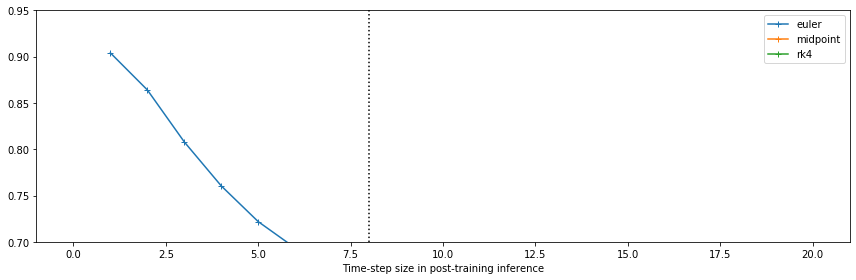

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


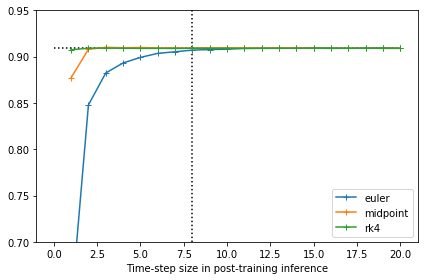

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


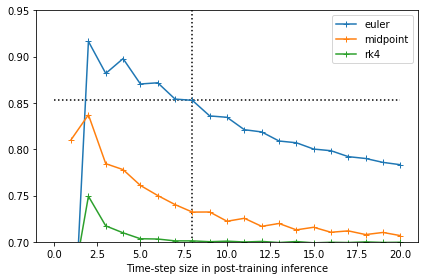

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


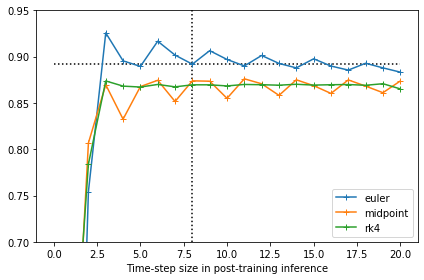

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


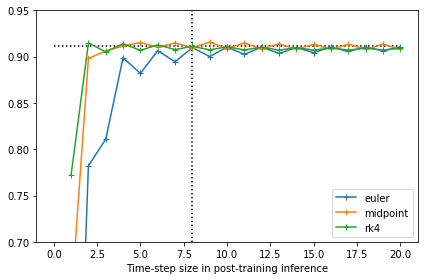

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


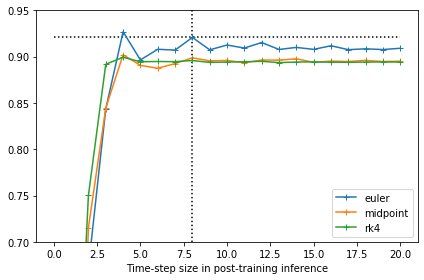

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


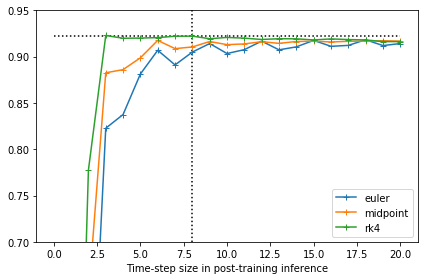

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


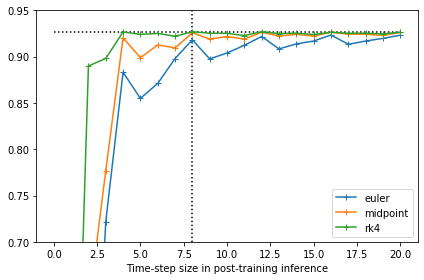

In [116]:
plt.figure(figsize=(12,4))
for name, accs_for_scheme in test_sweep.items():
    print(name)
#     if "[40, 80]" in name:
#         plt.subplot(132)
#         plt.title("Trained with refinement 40")
#     elif "[50, 100]" in name:
#         plt.subplot(133)
#         plt.title("Trained with refinement 50")
#     else:
#         plt.subplot(131)
#         plt.title("Trained without refinement")
#         plt.ylabel('Test set accuracy')
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        #if scheme in name:
        #    plt.semilogx(1.0/x[0],y[0],'o')
        # plt.vlines([3.0],0,1,linestyle='dotted')
        # plt.plot(x, y, label=scheme)

        if scheme in name:
            plt.hlines([y[7]],0,20.0, linestyles='dotted')
        # plt.semilogx([1.0/_x for _x in x], y, '+-', label=scheme)
        plt.plot(x, y, '+-', label=scheme)

    #plt.vlines([1.0/8.0],0,1,linestyles='dotted')
    plt.vlines([8.0],0,1,linestyles='dotted')
    plt.ylim(0.7,0.95)
    plt.legend()
    plt.xlabel('Time-step size in post-training inference')
    plt.tight_layout()
    plt.show()

In [26]:
set_ode_config(result.model_list[-1], 8, 'rk4_classic', use_adjoint=False)

# Plot the Weights

In [27]:
result.model_list[0].net[2].net.L1.weight.shape

torch.Size([2, 16, 16, 3, 3])

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


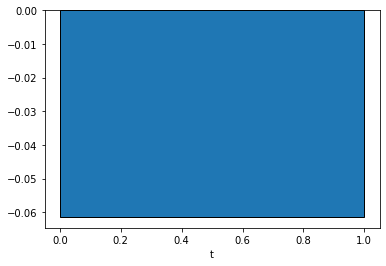

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-1-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


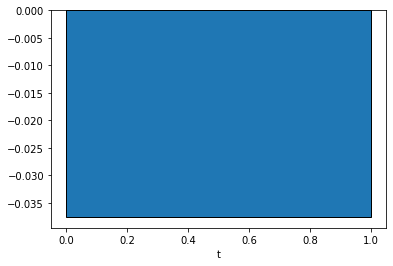

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


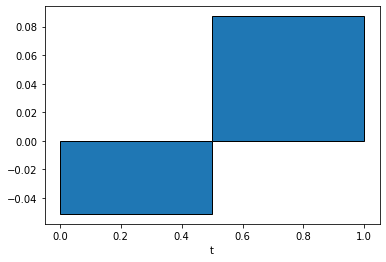

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


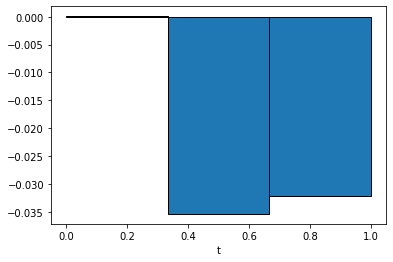

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-2-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


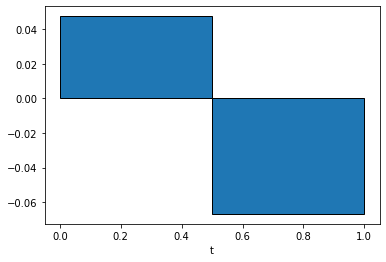

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-euler-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


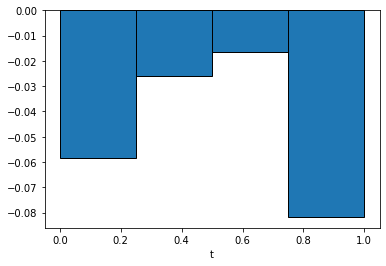

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-3-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


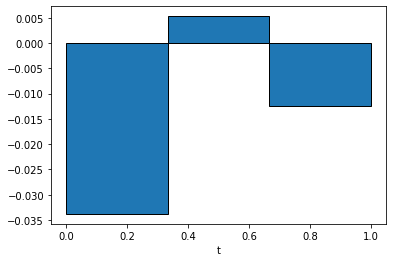

results/odenet-CIFAR10-SingleSegment-ARCH-16-ode-NoSkip-rk4_classic-4-1.0-1-piecewise-LEARN-0.1-160-None-0.1-Backprop-NormalInit-SEED-1.pkl


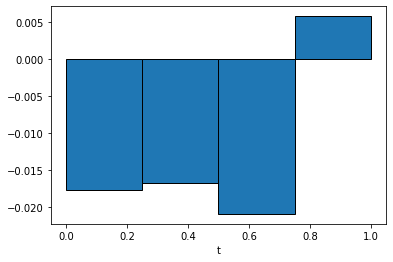

In [108]:
for name,result in results.items():
    i,j=0,0
    for a,b in [(2,2)]: #np.ndindex(result.model_list[0].net[2].net.L1.weight.shape[-2:]):
        print(name)
        plotting.plot_weights_over_time(
            result.model_list,
            lambda x : x.net[5].net.L1.weight[:,i,j,a,b].cpu(),
            lambda x : x.net[5].ts.cpu())


# Adjoint accuracy

In [64]:
criterion = torch.nn.CrossEntropyLoss()

In [65]:
def get_flat_grad(model):
    return torch.cat([ l.grad.flatten() for l in model.parameters() ])
def grad_wrt(model):
    model.zero_grad()
    out = model(imgs)
    L = criterion(out,labels)
    L.backward()
    return get_flat_grad(model)

In [69]:
name, result = next(iter(results.items()))

In [70]:
model = result.model_list[-1]
device = helper.which_device(model)
imgs, labels = next(iter(testloader))
imgs = imgs.to(device)
labels = labels.to(device)

In [90]:
name

'results/odenet-CIFAR10-SingleSegment-ARCH-16-False-SkipInit-rk4_classic-1-1.0-1-piecewise-LEARN-0.01-100-[50]-0.1-Backprop-NormalInit-SEED-1.pkl'

In [72]:
auto_grad

tensor([-0.0428, -0.0359, -0.0679,  ...,  0.0033, -0.0067, -0.0251],
       device='cuda:0')

In [103]:
nts = range(1,10)
approxes = {}
set_ode_config(model, 2, 'rk4_classic', False)
auto_grad = grad_wrt(model)
denominator = np.linalg.norm(auto_grad.cpu().numpy())
for scheme in ['rk4_classic', 'euler']:
    approxes[scheme] = []
    for i in nts:
        set_ode_config(model, i, scheme, True)
        approx_grad = grad_wrt(model)
        err = np.linalg.norm((auto_grad - approx_grad).cpu().numpy())/denominator
        approxes[scheme].append(err)

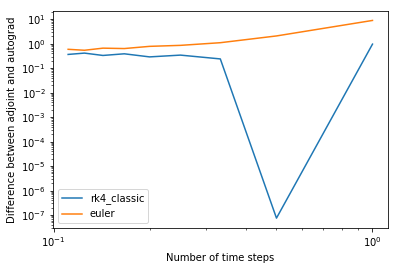

In [104]:
for scheme, approx in approxes.items():
    plt.loglog([1.0/_t for _t in nts],approx,label=scheme)
plt.xlabel("Number of time steps")
plt.ylabel("Difference between adjoint and autograd")
plt.legend()

In [95]:
approxes

{'rk4_classic': [0.9612521,
  7.302864e-08,
  0.23930673,
  0.34233332,
  0.28953344,
  0.387224,
  0.331518,
  0.41345862,
  0.3651575],
 'euler': [3.862687,
  9.624391e-08,
  0.780233,
  0.77960616,
  0.89037,
  0.86943847,
  0.9286262,
  0.9085805,
  0.9435202]}

In [105]:
nts = range(1,10)
approxes = {}

denominator = np.linalg.norm(auto_grad.cpu().numpy())
for scheme in ['rk4_classic', 'euler']:
    approxes[scheme] = []
    for i in nts:
        set_ode_config(model, i, scheme, False)
        auto_grad = grad_wrt(model)
        set_ode_config(model, i, scheme, True)
        approx_grad = grad_wrt(model)
        err = np.linalg.norm((auto_grad - approx_grad).cpu().numpy())/denominator
        approxes[scheme].append(err)

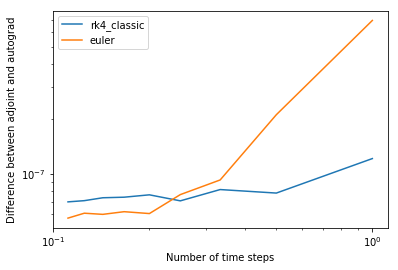

In [106]:
for scheme, approx in approxes.items():
    plt.loglog([1.0/_t for _t in nts],approx,label=scheme)
plt.xlabel("Number of time steps")
plt.ylabel("Difference between adjoint and autograd")
plt.legend()